In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
testData = tf.keras.utils.image_dataset_from_directory(
    directory = "SpectrogramData_Formatted/test",
    labels="inferred",
    label_mode = "categorical",
    color_mode="rgb",
    batch_size=64,
    image_size=(235, 352),
    shuffle=False,
    seed=42
)


Found 789 files belonging to 8 classes.


In [6]:
import keras.backend as K

def macro_f1_score(y_true, y_pred):
    """
    Calculate macro-average F1 score using Keras backend.

    Parameters:
        y_true (tensor or array): The true class labels (ground truth) as a tensor or Numpy array.
        y_pred (tensor or array): The predicted class labels as a tensor or Numpy array.

    Returns:
        float: The macro-average F1 score.
    """
    # Convert Numpy arrays to Keras backend tensors
    if not tf.is_tensor(y_true):
        y_true = K.constant(y_true)

    if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    
    # Calculate true positives, false positives, and false negatives for each class
    tp = K.sum(y_true * K.round(y_pred), axis=0)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)

    # Calculate precision and recall for each class
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1 score for each class
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Calculate macro-average F1 score
    macro_f1 = K.mean(f1_score)

    return macro_f1

In [8]:
############ Baseline ############
savedModelBaseline = tf.keras.models.load_model("SavedModels/best_model_baseline.h5", compile=False)
savedModelBaseline.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["accuracy", macro_f1_score])

loss, accuracy, macro_f1_score_ = savedModelBaseline.evaluate(testData)
print("Baseline")
print("Loss:", loss)
print("macro_f1_score: ", round((macro_f1_score_*100), 2), "%")
print("Accuracy: ", round((accuracy*100), 2), "%")


############ Aug1 ############
savedModelAug1 = tf.keras.models.load_model("SavedModels/best_model_Aug1.h5", compile=False)
savedModelAug1.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["accuracy", macro_f1_score])

loss, accuracy, macro_f1_score_ = savedModelAug1.evaluate(testData)
print("Aug1")
print("Loss:", loss)
print("macro_f1_score: ", round((macro_f1_score_*100), 2), "%")
print("Accuracy: ", round((accuracy*100), 2), "%")


############ Aug 2 ############
savedModelAug2 = tf.keras.models.load_model("SavedModels/best_model_Aug2.h5", compile=False)
savedModelAug2.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["accuracy", macro_f1_score])

loss, accuracy, macro_f1_score_ = savedModelAug2.evaluate(testData)
print("Aug2")
print("Loss:", loss)
print("macro_f1_score: ", round((macro_f1_score_*100), 2), "%")
print("Accuracy: ", round((accuracy*100), 2), "%")


13/13 [==============================] - 9s 536ms/step - loss: 1.7385 - accuracy: 0.3663 - macro_f1_score: 0.0675
Baseline
Loss: 1.7384847402572632
macro_f1_score:  6.75 %
Accuracy:  36.63 %
13/13 [==============================] - 8s 475ms/step - loss: 3.9083 - accuracy: 0.3346 - macro_f1_score: 0.0792
Aug1
Loss: 3.9082915782928467
macro_f1_score:  7.92 %
Accuracy:  33.46 %
13/13 [==============================] - 16s 1s/step - loss: 3.9424 - accuracy: 0.4132 - macro_f1_score: 0.1016
Aug2
Loss: 3.9424006938934326
macro_f1_score:  10.16 %
Accuracy:  41.32 %


# Plots (Accuracy, F1-score, Loss)

In [9]:
baselineMetrics = pd.read_csv("Baseline_metrics.csv")
aug1Metrics = pd.read_csv("Aug1_metrics.csv")
aug2Metrics = pd.read_csv("Aug2_metrics.csv")


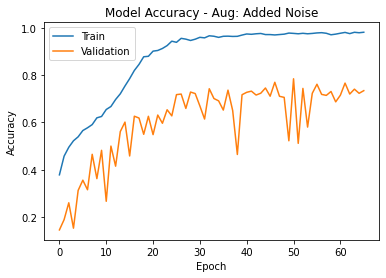

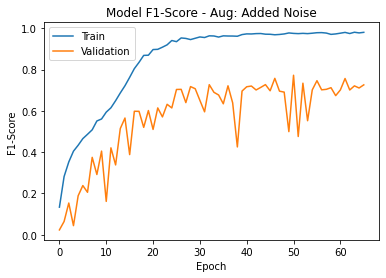

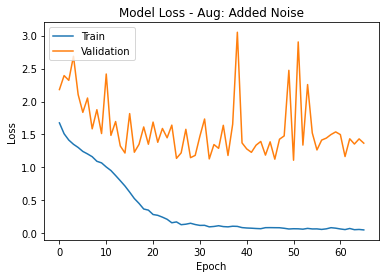

In [13]:
# https://stackoverflow.com/questions/66785014/how-to-plot-the-accuracy-and-and-loss-from-this-keras-cnn-model
import matplotlib.pyplot as plt

model = aug2Metrics

# summarize history for accuracy
plt.plot(model["accuracy"])
plt.plot(model['val_accuracy'])
plt.title("Model Accuracy - Aug: Added Noise")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.savefig("Plots/Aug2 Accuracy", bbox_inches="tight")
plt.show()


# summarize history for f1-score
plt.plot(model["macro_f1_score"])
plt.plot(model['val_macro_f1_score'])
plt.title("Model F1-Score - Aug: Added Noise")
plt.ylabel("F1-Score")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.savefig("Plots/Aug2 F1-score", bbox_inches="tight")
plt.show()


# summarize history for loss
plt.plot(model["loss"])
plt.plot(model['val_loss'])
plt.title("Model Loss - Aug: Added Noise")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.savefig("Plots/Aug2 Loss", bbox_inches="tight")
plt.show()

# Confusion Matrix

## Baseline

13/13 [==============================] - 7s 534ms/step
Found 789 images belonging to 8 classes.


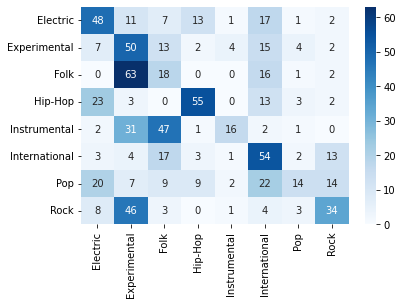

In [30]:
# Get predicted probabilities for each sample
predicted_probs = savedModelBaseline.predict(testData)

# Get true class labels and predicted class indices
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_data_flow = test_data_generator.flow_from_directory("SpectrogramData_Formatted/test", target_size=(235, 352), batch_size=64, shuffle=False)

true_labels = test_data_flow.classes
predicted_labels = np.argmax(predicted_probs, axis=1)

# Calculate the confusion matrix
confusion_mat_baseline = confusion_matrix(true_labels, predicted_labels)
class_labels = ["Electric", "Experimental", "Folk", "Hip-Hop", "Instrumental", "International", "Pop", "Rock"]
sns.heatmap(confusion_mat_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.savefig('confusion_matrix_Baseline.png', bbox_inches='tight')




## Augmentation 1

13/13 [==============================] - 6s 483ms/step
Found 789 images belonging to 8 classes.


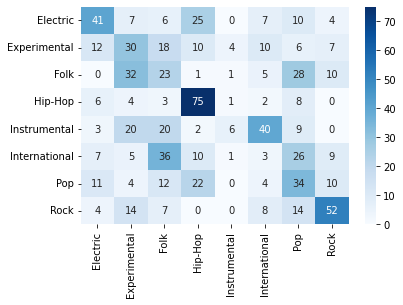

In [31]:
# Get predicted probabilities for each sample
predicted_probs = savedModelAug1.predict(testData)

# Get true class labels and predicted class indices
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_data_flow = test_data_generator.flow_from_directory("SpectrogramData_Formatted/test", target_size=(235, 352), batch_size=64, shuffle=False)

true_labels = test_data_flow.classes
predicted_labels = np.argmax(predicted_probs, axis=1)

# Calculate the confusion matrix
confusion_mat_aug1 = confusion_matrix(true_labels, predicted_labels)
class_labels = ["Electric", "Experimental", "Folk", "Hip-Hop", "Instrumental", "International", "Pop", "Rock"]
sns.heatmap(confusion_mat_aug1, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.savefig('confusion_matrix_Aug1.png', bbox_inches='tight')




## Diff Baseline to Aug1

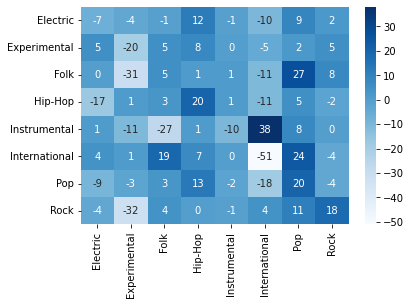

In [32]:
diffAug1 = confusion_mat_aug1 - confusion_mat_baseline
class_labels = ["Electric", "Experimental", "Folk", "Hip-Hop", "Instrumental", "International", "Pop", "Rock"]
sns.heatmap(diffAug1, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.savefig('confusion_matrix_diffAug1.png', bbox_inches='tight')


## Augmentation 2

13/13 [==============================] - 15s 1s/step
Found 789 images belonging to 8 classes.


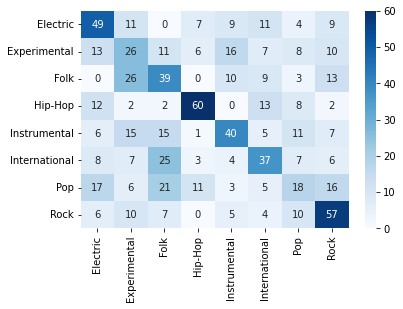

In [33]:
# Get predicted probabilities for each sample
predicted_probs = savedModelAug2.predict(testData)


# Get true class labels and predicted class indices
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_data_flow = test_data_generator.flow_from_directory("SpectrogramData_Formatted/test", target_size=(235, 352), batch_size=64, shuffle=False)

true_labels = test_data_flow.classes
predicted_labels = np.argmax(predicted_probs, axis=1)

# Calculate the confusion matrix
confusion_mat_aug2 = confusion_matrix(true_labels, predicted_labels)
class_labels = ["Electric", "Experimental", "Folk", "Hip-Hop", "Instrumental", "International", "Pop", "Rock"]
sns.heatmap(confusion_mat_aug2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.savefig('confusion_matrix_Aug2.png', bbox_inches='tight')



## Diff Baseline to Aug2

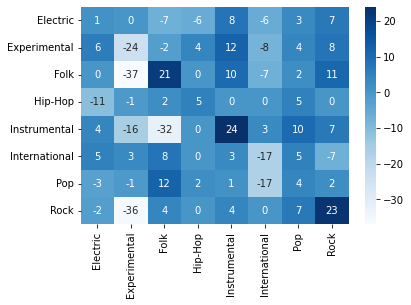

In [34]:
diffAug2 = confusion_mat_aug2 - confusion_mat_baseline
class_labels = ["Electric", "Experimental", "Folk", "Hip-Hop", "Instrumental", "International", "Pop", "Rock"]
sns.heatmap(diffAug2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.savefig('confusion_matrix_diffAug2.png', bbox_inches='tight')


# Saliency Map

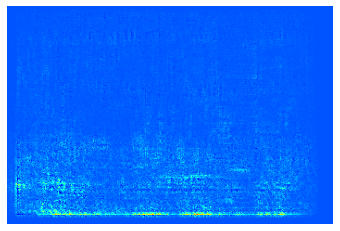

In [35]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

image_path = "SpectrogramData_Formatted/test/Electronic/35569.png"


def calculate_saliency(image_path, model):
    img = image.load_img(image_path, target_size=(235, 352))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        top_prediction = predictions[0, np.argmax(predictions)]
    gradient = tape.gradient(top_prediction, img_tensor)
    saliency_map = tf.reduce_max(gradient, axis=-1)
    
    # Normalize the saliency map
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) - tf.reduce_min(saliency_map))
    return saliency_map


saliency_map = calculate_saliency(image_path, savedModelBaseline)


# Visualize the saliency map
plt.imshow(saliency_map[0], cmap="jet")
plt.axis("off")
plt.show()
